# Categorical and quantitative data - hyperparameter tuning - LGBM 

### Techniques covered in this Notebook
- Preprocessing the categorical and quantitative data (excludes connectome matrices / MRI images)
- LGBM
- Hyperparameter tuning
- Feature importance

In [2]:
import numpy as np
import pandas as pd
import os
import csv
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import time  
import lightgbm as lgb 
from lightgbm import early_stopping, log_evaluation
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
import random
import itertools
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load the data

In [3]:
# Set model family name  no features excluded,  not applied in this version
model_family = 'LGBM_thresh_0_30_0_70_(100)_feat_mod7a'

Specify data input folder

In [4]:
# SET FOLDERS (LOCAL OR REMOTE - COLAB COVERED IN THIS CELL)

# Local folders 
data_input_folder = '../data'
output_folder = '../data/Interim'


# Colab 
# Mount drive 
#from google.colab import drive
#drive.mount('/content/drive')

# Set Colab folders
# data_input_folder = '/content/drive/MyDrive/WIDS_2025'
# output_folder = '/content/drive/MyDrive/WIDS_2025/Output'

Load training data

In [5]:
# Start runtime measurement
start_time                 = time.time()

# Load categorical data as category:
train_cat_features_input   = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_cat_features_input.sort_values(by='participant_id', inplace=True)

# Load additional categorical variables (extracted from connectome matrices)
cat_add_columns            = ['participant_id', 'avg_above_overall_avg']
train_cat_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TRAIN.csv")[cat_add_columns]
train_cat_features_add.sort_values(by='participant_id', inplace=True)

# Merge categorical features:
train_cat_features         = pd.merge(train_cat_features_input, train_cat_features_add, on='participant_id', how='left')
train_cat_features         = train_cat_features.astype('category')

# Load quantitative data:
train_quant_features_input = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_quant_features_input.sort_values(by='participant_id', inplace=True)

# Load additional quantitative variables (extracted from connectome matrices)
quant_add_columns          = ['participant_id', 'nr_of_cells_above_cell_avg', 'nr_of_cells_above_overall_avg', 'non_diagonal_diffs']
train_quant_features_add   = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TRAIN.csv")[quant_add_columns]
train_quant_features_add.sort_values(by='participant_id', inplace=True)

# Merge quantitative features:
train_quant_features         = pd.merge(train_quant_features_input, train_quant_features_add, on='participant_id', how='left')
train_quant_features         = train_quant_features.astype('category')

# Load solutions:
solution                   = pd.read_excel(f"{data_input_folder}/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
solution.sort_values(by='participant_id', inplace=True)
solution                   = solution.astype('category') 

train_merged               = pd.merge(train_cat_features, train_quant_features, on='participant_id', how='left')
train_merged               = pd.merge(train_merged, solution, on='participant_id', how='left')

# Dictionary of training data
train                      = {'mode': 'train',
                              'cat': train_cat_features,
                              'quant': train_quant_features,
                              'solution': solution,
                              'merged': train_merged}

Load test data

In [6]:
# Load categorical data as category:
test_cat_features_input   = pd.read_excel(f"{data_input_folder}/TEST/TEST_CATEGORICAL.xlsx")

# Load additional categorical variables (extracted from connectome matrices)
test_cat_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TEST.csv")[cat_add_columns]
test_cat_features_add.sort_values(by='participant_id', inplace=True)

# Merge categorical features:
test_cat_features         = pd.merge(test_cat_features_input, test_cat_features_add, on='participant_id', how='left')
test_cat_features         = test_cat_features.astype('category')

# Load quantitative data:
test_quant_features_input = pd.read_excel(f"{data_input_folder}/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Load additional quantitative variables (extracted from connectome matrices)
test_quant_features_add     = pd.read_csv(f"{data_input_folder}/Interim/connectome_averages_TEST.csv")[quant_add_columns]
test_quant_features_add.sort_values(by='participant_id', inplace=True)

# Merge quantitative features:
test_quant_features         = pd.merge(test_quant_features_input, test_quant_features_add, on='participant_id', how='left')
test_quant_features         = test_quant_features.astype('category')

# Merge datasets into one:
test_merged               = pd.merge(test_cat_features, test_quant_features, on='participant_id', how='left')

# Dictionary of training data
test                      = {'mode': 'TEST',
                             'cat': test_cat_features,
                             'quant': test_quant_features,
                             'solution': None,
                             'merged': test_merged}

## Set parameters

Set parameters for data preprocessing

In [7]:
data_preproc_params = {}

# Full list of 9 categorical variables:
#   Basic_Demos_Enroll_Year, Basic_Demos_Study_Site, PreInt_Demos_Fam_Child_Ethnicity, PreInt_Demos_Fam_Child_Race,	
#   MRI_Track_Scan_Location, Barratt_Barratt_P1_Edu, Barratt_Barratt_P1_Occ,           Barratt_Barratt_P2_Edu',      Barratt_Barratt_P2_Occ

# Full list of 18 quantitatigve variables:
#   EHQ_EHQ_Total,	            ColorVision_CV_Score,  APQ_P_APQ_P_CP,	          APQ_P_APQ_P_ID,	         APQ_P_APQ_P_INV,   
#   APQ_P_APQ_P_OPD	            APQ_P_APQ_P_PM,	       APQ_P_APQ_P_PP	          SDQ_SDQ_Conduct_Problems,	 SDQ_SDQ_Difficulties_Total, 
#   SDQ_SDQ_Emotional_Problems	SDQ_SDQ_Externalizing, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Hyperactivity	     SDQ_SDQ_Internalizing	
#   SDQ_SDQ_Peer_Problems,      SDQ_SDQ_Prosocial,     MRI_Track_Age_at_Scan

data_preproc_params['cat_columns_to_drop']   = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']
#                                                    
data_preproc_params['quant_columns_to_drop'] = []  

# Specify if Principal Component Analysis (PCA) should be used for dimension reduction for quantitative features and connectome matrices:
# If yes specify the number of principal components
data_preproc_params['apply_pca_quant']                       = False
data_preproc_params['nr_pca_components_quant']               = 2

# Set imputer methods:
data_preproc_params['categorical_imputer_strategy']          = 'most_frequent'         # Options: 'most frequent' 

data_preproc_params['numeric_imputer']                       = 'iterative'             # Options: 'iterative' or 'simple'
                                                                                       # In case 'iterative' selected then a RF regression will be performed
data_preproc_params['numeric_imputer_strategy']              = None                    # Options for simple: 'median', 'mean', 'most freqent', 'constant'
                                                                          # No options for iterative

Set model hyperparameters

In [8]:
# Size of random sample selected from hyperparameter range
n_samples = 100

# Range for 
threshold_range = np.linspace(0.0, 1.0, 21)

model_param_ranges = {
    'sex': {
        'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047],  # Wider range of num_leaves
        'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.04],  # Expanded learning rate range
        'n_estimators': {'min': 100, 'max': 1000, 'step': 100},  # Will be expanded to a list in sampling
        'max_depth': [3, 5, 7, 9, 12, 15],
        'min_data_in_leaf': [1, 3, 5, 10, 20, 50, 100],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'lambda_l1': [0, 0.1, 0.5, 1.0, 2.0],
        'lambda_l2': [0, 0.1, 0.5, 1.0, 2.0],
        'early_stopping_rounds': [50],  # fixed parameter
        'verbose': [-1]  # fixed parameter

    },

    'adhd': {
        'num_leaves': [15, 31, 63, 127],  # Wider range of num_leaves
        'learning_rate': [0.001, 0.005, 0.01, 0.02],  # Expanded learning rate range
        'n_estimators': {'min': 100, 'max': 500, 'step': 100},  # Will be expanded to a list in sampling
        'max_depth': [3, 5, 7],
        'min_data_in_leaf': [10, 20, 50],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'lambda_l1': [0, 0.1, 0.5, 1.0, 2.0],
        'lambda_l2': [0, 0.1, 0.5, 1.0, 2.0],
        'early_stopping_rounds': [50],  # fixed parameter
        'verbose': [-1]  # fixed parameter                           
    }
}


Set model evaluation parameters

In [9]:
# Number of folds (k) for k-fold cross-validation:
nr_of_folds      = 5 

## Data preprocessing

Define Principal Component Analysis (PCA)

In [10]:
def drop_columns(data, data_preproc_params):
    
    mode = data['mode']

    # Merge categorical and quantitative columns to drop (no columns dropped from connectome matrix):
    cat_columns_to_drop = data_preproc_params['cat_columns_to_drop']
    quant_columns_to_drop = data_preproc_params['quant_columns_to_drop']

    # Drop selected columns for categorical and quantitative data:
    data['cat'] = data['cat'].drop(cat_columns_to_drop, axis=1)
    data['quant'] = data['quant'].drop(quant_columns_to_drop, axis=1)

    # Merge cat and quant
    data['merged'] = pd.merge(data['cat'], data['quant'], on='participant_id', how='left')

    # Merge solution in TRAIN mode only
    if mode == 'TRAIN':
        solution = data['solution']  # <-- important!
        data['merged'] = pd.merge(data['merged'], solution, on='participant_id', how='left')

    return data

In [11]:
def preprocess_data_fit(data, data_preproc_params):
    """
    Perform data preprocessing on training or test data.
    If training, includes PCA fitting.
    """
    apply_pca_quant = data_preproc_params['apply_pca_quant']
    nr_pca_components_quant = data_preproc_params['nr_pca_components_quant']

    # Retrieved merged data
    data_merged = data['merged']

    # Drop participant id and target columns
    X = data_merged.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1, errors='ignore')

    # Identify feature types
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    # Get imputers
    numeric_imputer = data_preproc_params['numeric_imputer']
    numeric_imputer_strategy = data_preproc_params['numeric_imputer_strategy']
    categorical_imputer_strategy = data_preproc_params['categorical_imputer_strategy']

    # Numeric pipeline steps list
    numeric_transformer_steps = [
        ('imputer', SimpleImputer(strategy=numeric_imputer_strategy)),
        ('scaler', StandardScaler())
    ] if numeric_imputer == 'simple' else [
        ('imputer', IterativeImputer(random_state=0)),
        ('scaler', StandardScaler())
    ]

    # Add PCA to the numeric pipeline steps list if PCA is required
    if apply_pca_quant:
        numeric_transformer_steps.append(('pca', PCA(n_components=nr_pca_components_quant)))

    # Create the numeric pipeline with the updated steps
    numeric_transformer = Pipeline(steps=numeric_transformer_steps)

    # Categorical pipeline (only imputing missing values, no one-hot encoding)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=categorical_imputer_strategy))
        # No OneHotEncoder here anymore
    ])

    # Full preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Fit preprocessor on training data
    preprocessor.fit(X)

    # After preprocessing, numerical features are scaled (and PCA'd optionally)
    # and categorical features are still intact (just missing values filled)
    # So feature names are just numerical + categorical original names

    return preprocessor


In [12]:
def preprocess_data_transform(data, preprocessor):
    """
    Apply data preprocessing (including PCA transformation if requested) to data.
    Uses the provided preprocessor and applies transformations.
    """
    # Preprocess data with the provided preprocessor
    data_merged = data['merged']
    
    # Ensure you select the correct features based on your ColumnTransformer
    X = data_merged.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1, errors='ignore')

    # Apply preprocessing (numeric and categorical transformations)
    data_transformed = preprocessor.transform(X)
    
    # Convert the transformed data to a DataFrame
    data_transformed_df = pd.DataFrame(
        data_transformed, 
        index=X.index,
        columns=preprocessor.get_feature_names_out()
    )

    print('Data transformed df cols:', data_transformed_df.columns)
    print('Data transformed df shape:', data_transformed_df.shape)

    # No need for PCA application here since it's done in preprocessing

    return data_transformed_df

Drop unused columns

In [13]:
train                               = drop_columns(train, data_preproc_params)
test                                = drop_columns(test, data_preproc_params)

Perform data preprocessing (fit preprocessor and perform PCA if required)

In [14]:
preprocessor = preprocess_data_fit(train, data_preproc_params)

Perform data transformation to prepare data for training

In [15]:
X_preprocessed_train                = preprocess_data_transform(train, preprocessor)
X_preprocessed_test                 = preprocess_data_transform(test, preprocessor)

Data transformed df cols: Index(['cat__PreInt_Demos_Fam_Child_Ethnicity',
       'cat__PreInt_Demos_Fam_Child_Race', 'cat__Barratt_Barratt_P1_Edu',
       'cat__Barratt_Barratt_P1_Occ', 'cat__Barratt_Barratt_P2_Edu',
       'cat__Barratt_Barratt_P2_Occ', 'cat__avg_above_overall_avg',
       'cat__EHQ_EHQ_Total', 'cat__ColorVision_CV_Score',
       'cat__APQ_P_APQ_P_CP', 'cat__APQ_P_APQ_P_ID', 'cat__APQ_P_APQ_P_INV',
       'cat__APQ_P_APQ_P_OPD', 'cat__APQ_P_APQ_P_PM', 'cat__APQ_P_APQ_P_PP',
       'cat__SDQ_SDQ_Conduct_Problems', 'cat__SDQ_SDQ_Difficulties_Total',
       'cat__SDQ_SDQ_Emotional_Problems', 'cat__SDQ_SDQ_Externalizing',
       'cat__SDQ_SDQ_Generating_Impact', 'cat__SDQ_SDQ_Hyperactivity',
       'cat__SDQ_SDQ_Internalizing', 'cat__SDQ_SDQ_Peer_Problems',
       'cat__SDQ_SDQ_Prosocial', 'cat__MRI_Track_Age_at_Scan',
       'cat__nr_of_cells_above_cell_avg', 'cat__nr_of_cells_above_overall_avg',
       'cat__non_diagonal_diffs'],
      dtype='object')
Data transformed d

## Model training and hyperparameter tuning

Define weighted F1 score (evaluation metric specified in the Datathon where females have double weight for ADHD prediction)

In [16]:
def get_weighted_f1(y_true, y_pred, sex, female_weight = 2.0, male_weight = 1.0):

    sample_weight = np.where(sex == 1, female_weight, male_weight)
    return f1_score(y_true, y_pred, average='binary', sample_weight=sample_weight)

### Train model on a grid of hyperparameters and select the best model (highest F1 score)

Expand parameter ranges for hypermarameter tuning (using model_param_ranges )

In [17]:
def sample_param_grid(param_dict, n_samples=n_samples, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    # Expand any param defined with min/max/step
    expanded = {}
    for key, value in param_dict.items():
        if isinstance(value, dict) and {'min', 'max', 'step'}.issubset(value.keys()):
            expanded[key] = list(range(value['min'], value['max'] + 1, value['step']))
        else:
            expanded[key] = value

    # Now sample from the full grid
    keys = list(expanded.keys())
    all_combinations = list(itertools.product(*(expanded[key] for key in keys)))
    print(f"Total possible combinations: {len(all_combinations)}")

    sampled_combinations = random.sample(all_combinations, min(n_samples, len(all_combinations)))

    # Convert list of tuples to list of dicts
    sampled_param_dicts = [dict(zip(keys, combo)) for combo in sampled_combinations]
    return sampled_param_dicts


Define function for hyperparameter tuning and model selection

In [18]:
def select_best_model(X_preprocessed_train, y_actual, nr_of_folds, model_param_ranges,
                      target, y_true_sex=None, n_samples=n_samples):

    best_metric = -1
    best_model = None
    best_params = None
    best_oof_probs = None
    fixed_threshold = 0.5

    param_grid = sample_param_grid(model_param_ranges[target], n_samples=n_samples)

    skf = StratifiedKFold(n_splits=nr_of_folds, shuffle=True, random_state=42)

    for i, param_combo in enumerate(param_grid, start=1):

        oof_preds = np.zeros(len(y_actual))

        for train_idx, val_idx in skf.split(X_preprocessed_train, y_actual):
            X_train, X_val = X_preprocessed_train.iloc[train_idx], X_preprocessed_train.iloc[val_idx]
            y_train, y_val = y_actual.iloc[train_idx], y_actual.iloc[val_idx]

            model = lgb.LGBMClassifier(
                objective='binary',
                metric='binary_logloss',
                **param_combo
            )

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)]
            )

            preds = model.predict_proba(X_val)[:, 1]
            oof_preds[val_idx] = preds

        y_pred = (oof_preds > fixed_threshold).astype(int)

        if target == 'adhd':
            metric = get_weighted_f1(y_actual, y_pred, y_true_sex)
        else:
            metric = f1_score(y_actual, y_pred)

        if metric > best_metric:
            best_metric = metric
            best_model = model  # Use the model from the cross-validation loop
            best_params = param_combo
            best_oof_probs = oof_preds

        if i % 50 == 0:
            print(f"{i} parameter combinations processed for {target} model selection | Best F1: {best_metric:.4f}")

    best_params['fixed_threshold'] = fixed_threshold
    return best_model, best_metric, best_params, best_oof_probs

Set ADHD and set models to the best ones. Note that the best F1 scores here are not the final ones as they were calculated using a prediction threshold of 0.5 (to be optimised in the following step)

In [19]:
# Specify actual labels:
y_actual_sex  = train_merged['Sex_F'].astype(int)  # Ensure this aligns 100% with X_preprocessed_train
y_actual_adhd = train_merged['ADHD_Outcome'].astype(int)  # Ensure this aligns 100% with X_preprocessed_train

# Train sex model first
sex_model, best_f1_sex, best_params_sex, best_oof_probs_sex = select_best_model(
    X_preprocessed_train, y_actual_sex, nr_of_folds, model_param_ranges, target='sex')

# Then ADHD model
adhd_model,  best_f1_adhd, best_params_adhd, best_oof_probs_adhd = select_best_model(
    X_preprocessed_train, y_actual_adhd, nr_of_folds, model_param_ranges, target='adhd',
    y_true_sex = y_actual_sex)

Total possible combinations: 15120000
50 parameter combinations processed for sex model selection | Best F1: 0.2222
100 parameter combinations processed for sex model selection | Best F1: 0.2362
Total possible combinations: 648000
50 parameter combinations processed for adhd model selection | Best F1: 0.8583
100 parameter combinations processed for adhd model selection | Best F1: 0.8583


Print interim best F1 scores (with prediction threshold = 0.5)

In [20]:
print('Best interim F1 score for ADHD - weighted with double weights for females: ', round(best_f1_adhd, 4))
print('Best interim F1 score for Sex - unweighted: ', round(best_f1_sex, 4))

Best interim F1 score for ADHD - weighted with double weights for females:  0.8583
Best interim F1 score for Sex - unweighted:  0.2362


Find best threshold for prediction:

In [21]:
def find_best_threshold(y_true, best_oof_probs, target, y_true_sex=None, plot=True):
    thresholds = threshold_range
    metrics = []

    for t in thresholds:
        y_pred = (best_oof_probs > t).astype(int)
        metric = (
            f1_score(y_true, y_pred) if target == 'sex'
            else get_weighted_f1(y_true, y_pred, y_true_sex)
        )
        metrics.append(metric)

    best_idx = np.argmax(metrics)
    best_threshold = thresholds[best_idx]
    best_metric = metrics[best_idx]

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, metrics, marker='o')
        plt.scatter(best_threshold, best_metric, color='red', label=f'Best threshold = {best_threshold:.3f}')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score' if target == 'sex' else 'Weighted F1 Score')
        plt.title(f'F1 Score vs Threshold for {target}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return best_threshold, best_metric


Print highest F1 scores and corresponding thresholds

ADHD

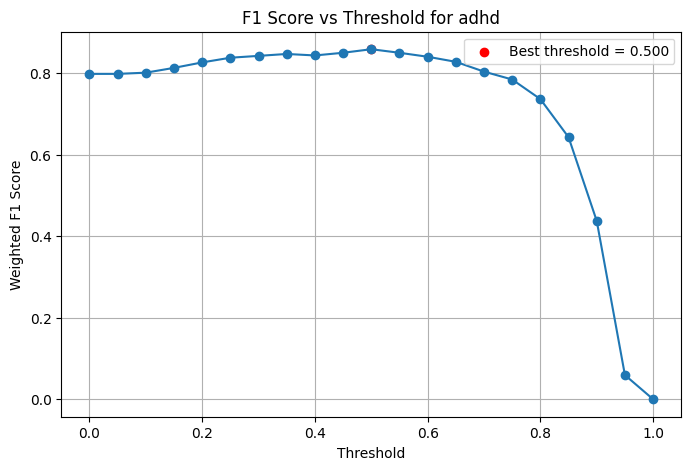

For ADHD prediction the best prediction threshold is 0.5
Highest F1 score for sex ADHD with LGBM_thresh_0_30_0_70_(100)_feat_mod7a: 0.8583

  num_leaves: 127
  learning_rate: 0.02
  n_estimators: 200
  max_depth: 3
  min_data_in_leaf: 50
  subsample: 0.8
  colsample_bytree: 0.6
  lambda_l1: 0.5
  lambda_l2: 2.0
  early_stopping_rounds: 50
  verbose: -1
  fixed_threshold: 0.5


In [22]:
# Determine best threshold and best F1 score
best_threshold_adhd, best_f1_score_adhd = find_best_threshold(y_actual_adhd, best_oof_probs_adhd, 'adhd', y_actual_sex)

print(f'For ADHD prediction the best prediction threshold is {best_threshold_adhd}')
print(f'Highest F1 score for sex ADHD with {model_family}: {round(best_f1_score_adhd, 4)}\n')
for param, value in best_params_adhd.items():
    print(f"  {param}: {value}")

Sex

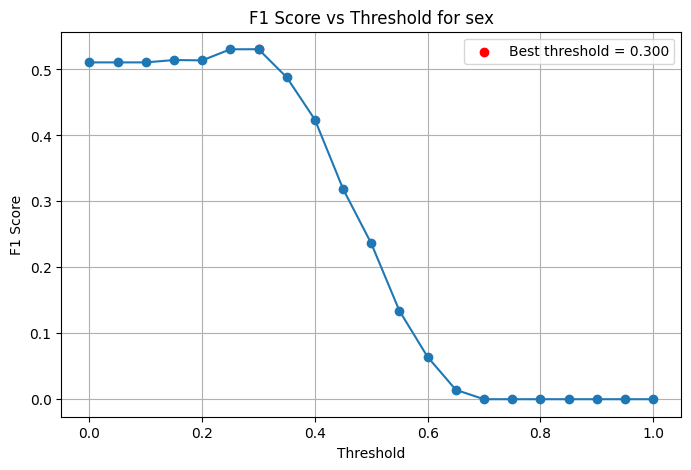

For sex prediction the best prediction threshold is 0.30000000000000004
Highest F1 score for sex with LGBM_thresh_0_30_0_70_(100)_feat_mod7a: 0.5307]

  num_leaves: 511
  learning_rate: 0.04
  n_estimators: 800
  max_depth: 7
  min_data_in_leaf: 20
  subsample: 1.0
  colsample_bytree: 0.9
  lambda_l1: 2.0
  lambda_l2: 1.0
  early_stopping_rounds: 50
  verbose: -1
  fixed_threshold: 0.5


In [23]:
# Determine best threshold for Sex
best_threshold_sex, best_f1_score_sex = find_best_threshold(y_actual_sex, best_oof_probs_sex, 'sex')
print(f'For sex prediction the best prediction threshold is {best_threshold_sex}')
print(f'Highest F1 score for sex with {model_family}: {round(best_f1_score_sex, 4)}]\n')
for param, value in best_params_sex.items():
    print(f"  {param}: {value}")

## Feature importance

### Feature importance - gain

ADHD

In [24]:
adhd_feature_importances = adhd_model.booster_.feature_importance(importance_type='gain')
adhd_feature_names       = adhd_model.booster_.feature_name()

adhd_importance_df = pd.DataFrame({
    'feature': adhd_feature_names,
    'importance': adhd_feature_importances
}).sort_values('importance', ascending=False)

print(adhd_importance_df)

                                  feature   importance
20             cat__SDQ_SDQ_Hyperactivity  5985.132565
18             cat__SDQ_SDQ_Externalizing  1461.377312
16        cat__SDQ_SDQ_Difficulties_Total  1204.975928
19         cat__SDQ_SDQ_Generating_Impact   787.820038
12                   cat__APQ_P_APQ_P_OPD   192.744361
27                cat__non_diagonal_diffs   177.461072
24             cat__MRI_Track_Age_at_Scan   160.927327
11                   cat__APQ_P_APQ_P_INV   145.417002
3             cat__Barratt_Barratt_P1_Occ   143.052963
15          cat__SDQ_SDQ_Conduct_Problems   113.990421
14                    cat__APQ_P_APQ_P_PP   106.327248
1        cat__PreInt_Demos_Fam_Child_Race    97.967533
26     cat__nr_of_cells_above_overall_avg    88.943532
25        cat__nr_of_cells_above_cell_avg    84.180300
17        cat__SDQ_SDQ_Emotional_Problems    84.147089
13                    cat__APQ_P_APQ_P_PM    80.430145
5             cat__Barratt_Barratt_P2_Occ    76.427700
4         

Sex

In [25]:
sex_feature_importances = sex_model.booster_.feature_importance(importance_type='gain')
sex_feature_names       = sex_model.booster_.feature_name()

sex_importance_df = pd.DataFrame({
    'feature': sex_feature_names,
    'importance': sex_feature_importances
}).sort_values('importance', ascending=False)

print(sex_importance_df)

                                  feature  importance
20             cat__SDQ_SDQ_Hyperactivity  273.474752
17        cat__SDQ_SDQ_Emotional_Problems  268.641460
25        cat__nr_of_cells_above_cell_avg  259.181480
5             cat__Barratt_Barratt_P2_Occ  216.243353
7                      cat__EHQ_EHQ_Total  194.534418
23                 cat__SDQ_SDQ_Prosocial  178.374224
24             cat__MRI_Track_Age_at_Scan  176.532099
13                    cat__APQ_P_APQ_P_PM  163.422298
27                cat__non_diagonal_diffs  159.408181
21             cat__SDQ_SDQ_Internalizing  146.411154
11                   cat__APQ_P_APQ_P_INV  145.702705
14                    cat__APQ_P_APQ_P_PP  127.245248
3             cat__Barratt_Barratt_P1_Occ  126.801223
1        cat__PreInt_Demos_Fam_Child_Race  124.834870
26     cat__nr_of_cells_above_overall_avg  122.416419
10                    cat__APQ_P_APQ_P_ID  109.685047
8               cat__ColorVision_CV_Score   79.742200
12                   cat__AP

Distinguish between important and not important features

In [26]:
# First, add cumulative importance columns
adhd_importance_df['cumulative_importance'] = adhd_importance_df['importance'].cumsum() / adhd_importance_df['importance'].sum()
sex_importance_df['cumulative_importance']  = sex_importance_df['importance'].cumsum() / sex_importance_df['importance'].sum()

# Select features that contribute to >90% of importance
adhd_important_features = adhd_importance_df[adhd_importance_df['cumulative_importance'] <= 0.90]['feature'].tolist()
sex_important_features  = sex_importance_df[sex_importance_df['cumulative_importance']  <= 0.90]['feature'].tolist()

# Print kept features
print("Important features for ADHD prediction (>90% importance):")
print(adhd_important_features)

print("\nImportant features for Sex prediction (>90% importance):")
print(sex_important_features)

# Now create a list of features to drop:
# Features that are NOT important for either ADHD or Sex prediction

# Combine all features
all_features = set(adhd_importance_df['feature'].tolist()) | set(sex_importance_df['feature'].tolist())

# Features that are important for either ADHD or Sex
important_features = set(adhd_important_features) | set(sex_important_features)

# Features to drop = features not in important_features
features_to_drop = list(all_features - important_features)

print("\nFeatures to drop (not important for either):")
print(features_to_drop)

Important features for ADHD prediction (>90% importance):
['cat__SDQ_SDQ_Hyperactivity', 'cat__SDQ_SDQ_Externalizing', 'cat__SDQ_SDQ_Difficulties_Total', 'cat__SDQ_SDQ_Generating_Impact', 'cat__APQ_P_APQ_P_OPD', 'cat__non_diagonal_diffs', 'cat__MRI_Track_Age_at_Scan', 'cat__APQ_P_APQ_P_INV']

Important features for Sex prediction (>90% importance):
['cat__SDQ_SDQ_Hyperactivity', 'cat__SDQ_SDQ_Emotional_Problems', 'cat__nr_of_cells_above_cell_avg', 'cat__Barratt_Barratt_P2_Occ', 'cat__EHQ_EHQ_Total', 'cat__SDQ_SDQ_Prosocial', 'cat__MRI_Track_Age_at_Scan', 'cat__APQ_P_APQ_P_PM', 'cat__non_diagonal_diffs', 'cat__SDQ_SDQ_Internalizing', 'cat__APQ_P_APQ_P_INV', 'cat__APQ_P_APQ_P_PP', 'cat__Barratt_Barratt_P1_Occ', 'cat__PreInt_Demos_Fam_Child_Race', 'cat__nr_of_cells_above_overall_avg', 'cat__APQ_P_APQ_P_ID', 'cat__ColorVision_CV_Score']

Features to drop (not important for either):
['cat__PreInt_Demos_Fam_Child_Ethnicity', 'cat__SDQ_SDQ_Peer_Problems', 'cat__APQ_P_APQ_P_CP', 'cat__Barratt_

## Model Evaluation

### Model Evaluation - ADHD

Model performance (ADHD)

In [27]:
# Use predicted labels from model
y_true              = y_actual_adhd
y_true_sex          = y_actual_sex
best_oof_preds_adhd = (best_oof_probs_adhd> best_threshold_adhd).astype(int)
y_pred              = best_oof_preds_adhd 

# Flatten if needed
y_true = np.ravel(y_true)
y_pred = np.ravel(y_pred)

# Metrics 
# Note: for weighted F1, the sex target variable is used (as per competition rules, in the ADHD F1 score females have double weight)
weighted_f1 = get_weighted_f1(y_true, y_pred, y_true_sex)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("Weighted F1 score:", round(weighted_f1, 4))
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

Weighted F1 score: 0.8583
F1 score: 0.8631
Precision: 0.8143
Recall: 0.9182
Accuracy: 0.8005


Confusion matrix (ADHD)

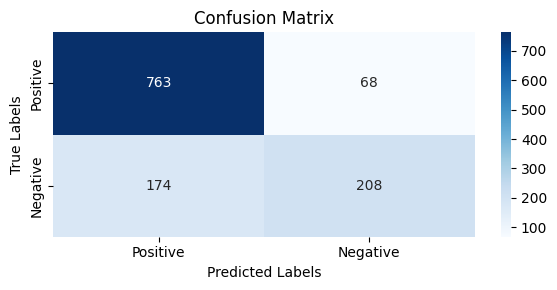

In [28]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

### Model Evaluation - Sex model (best)

Model performance

In [29]:
# Set sex predictions on the validation set based on the optimised (best) threshold and probabilities
y_true             = y_true_sex
best_oof_preds_sex = (best_oof_probs_sex > best_threshold_sex).astype(int)
y_pred             = best_oof_preds_sex  

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Output
print("F1 score:", round(f1, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("Accuracy:", round(accuracy, 4))

F1 score: 0.5307
Precision: 0.4114
Recall: 0.7476
Accuracy: 0.5466


Confusion matrix

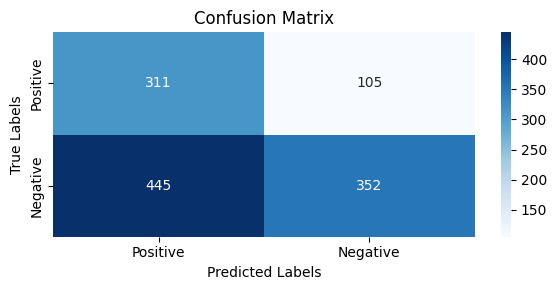

In [30]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: [TP, FN], [FP, TN] format
# If you want to follow your previous manual format:
conf_matrix = np.array([[cm[1,1], cm[1,0]],
                        [cm[0,1], cm[0,0]]])

# Plot
cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=categories)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


## Prediction on the training validation set (for meta classification)

Include ADHD predictions and probabilities on the trainig validation dataset in a pandas dataframe and save to a csv file.

print(solution.head())

In [31]:
participant_id_train = solution.index

train_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_train,  # This should be your patient_id array
    'pred_sex': best_oof_preds_sex, 
    'prob_sex': best_oof_probs_sex, 
    'pred_adhd': best_oof_preds_adhd,  
    'prob_adhd': best_oof_probs_adhd  
})

# Save to CSV
train_pred_prob_df.to_csv(f"{output_folder}/{model_family}_train_pred_prob.csv", index=False)

## Prediction on the test set

Evaluate model on the test data

In [32]:
# Calculate probabilities of belonging to a certain class on the training data
y_probs_test_sex = sex_model.predict_proba(X_preprocessed_test)[:, 1]
y_probs_test_adhd = adhd_model.predict_proba(X_preprocessed_test)[:, 1]

# Use probabilities to perform model prediction on the training data
y_pred_test_sex = (y_probs_test_sex > best_threshold_sex).astype(int)
y_pred_test_adhd = (y_probs_test_adhd> best_threshold_adhd).astype(int)

# Retrieve participant id from the training data
test_cat            = test['cat']
participant_id_test = test_cat['participant_id']

# Check first 10 predicted probabilities for sex model
print("First 10 predicted probabilities (Sex model):")
print(y_probs_test_sex[:10])

# Check first 10 predicted probabilities for adhd model
print("First 10 predicted probabilities (ADHD model):")
print(y_probs_test_adhd[:10])

First 10 predicted probabilities (Sex model):
[0.22066338 0.5948388  0.43498691 0.30390838 0.27461939 0.42496964
 0.35538907 0.34011773 0.39255672 0.40967835]
First 10 predicted probabilities (ADHD model):
[0.73850476 0.77175893 0.68602251 0.90286405 0.94099872 0.72383927
 0.54796694 0.23931696 0.66322155 0.91654084]


In [33]:
test_pred_prob_df = pd.DataFrame({
    'participant_id': participant_id_test, 
    'pred_sex': y_pred_test_sex, 
    'prob_sex': y_probs_test_sex, 
    'pred_adhd': y_pred_test_adhd,  
    'prob_adhd': y_probs_test_adhd 
})

# Save to CSV
test_pred_prob_df.to_csv(f"{output_folder}/{model_family}_test_pred_prob.csv", index=False)

Include preditions on the test dataset to a pandas dataframe and save to a submission csv file.

In [34]:
submission_cnn_adhd = pd.DataFrame({
    'participant_id': participant_id_test,  # Updated to correct test dataset patient IDs
    'ADHD_Outcome': y_pred_test_adhd,
    'Sex_F': y_pred_test_sex
})

# Save to CSV
submission_cnn_adhd.to_csv(f"{output_folder}/submission_{model_family}.csv", index=False)


In [35]:
# Print runtime
end_time = time.time()
runtime = round((end_time - start_time)/60, 1)
print('Total runtime  is ', runtime, 'minutes')

Total runtime  is  2.3 minutes
